In [1]:
from pathlib import Path
import albumentations as A
from sklearn.model_selection import train_test_split
from fastai.vision.all import *
from fastai.callback.tracker import EarlyStoppingCallback

/opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 42
VAL_RATIO = 0.2
IMAGE_SIZE = 224
EPOCH = 20
BS = 32
DATASET_ROOT = Path("butterfly-image-classification")
CSV_PATH = DATASET_ROOT / Path("Training_set.csv")

In [3]:
def set_seed(x=42):
    random.seed(x)
    np.random.seed(x)
    torch.manual_seed(x)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(x)

set_seed(SEED)

In [4]:
class AlbumentationsTransform(DisplayedTransform):
    split_idx, order = 0, 2

    def __init__(self, train_aug):
        store_attr()

    def encodes(self, img: PILImage):
        aug_img = self.train_aug(image=np.array(img))["image"]
        return PILImage.create(aug_img)


def get_train_aug():
    return A.Compose(
        [   A.HorizontalFlip(),
            A.VerticalFlip(),
            A.RandomBrightnessContrast(),
            A.HueSaturationValue(),
            A.CoarseDropout()
        ]
    )

dblock = DataBlock(
        blocks = (ImageBlock, CategoryBlock),
        get_x = ColReader(['filename'], pref=f'{str(DATASET_ROOT)}/train/'), 
        get_y = ColReader(['label']), 
        splitter=TrainTestSplitter(test_size=VAL_RATIO, random_state=SEED, shuffle=True),
        item_tfms=[AlbumentationsTransform(get_train_aug()), Resize(IMAGE_SIZE), ToTensor],
        batch_tfms=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)],
    )

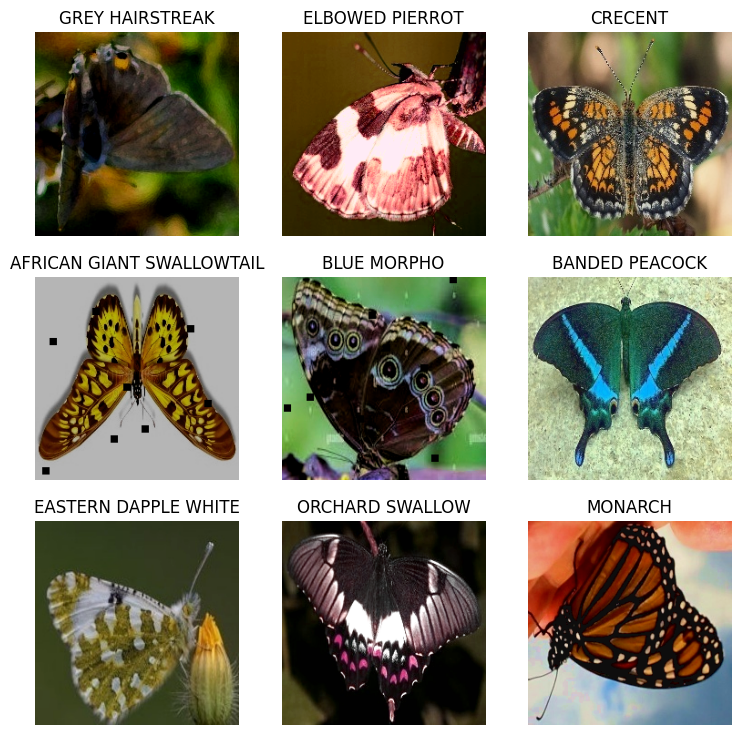

In [5]:
train_df = pd.read_csv(CSV_PATH)
dls = dblock.dataloaders(train_df,bs=BS)
dls.show_batch()

In [6]:
import torch.nn as nn

class VanillaCNN(nn.Module):
    def __init__(self,input_dims=3,num_classes=50,dropout=0.):
        super().__init__()
        self.block_0=nn.Sequential(
            nn.Conv2d(input_dims,64,3),
            nn.BatchNorm2d(64),#添上一层
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block_1=nn.Sequential(
            nn.Conv2d(64,256,3),
            nn.BatchNorm2d(256),#添上一层
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block_2=nn.Sequential(
            nn.Conv2d(256,128,3),
            nn.BatchNorm2d(128),#添上一层
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block_3=nn.Sequential(
            nn.Conv2d(128,64,3),
            nn.BatchNorm2d(64),#添上一层
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block_4=nn.Sequential(
            nn.Conv2d(64,32,3),
            nn.BatchNorm2d(32),#添上一层
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block_5=nn.Sequential(
            nn.Conv2d(32,32,3),
            nn.BatchNorm2d(32),#添上一层
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )
        self.head=nn.Sequential(
            nn.Linear(32,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128,64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64,num_classes)
        )
    
    def forward(self, x=None ,pretrained=None):
        x = self.block_0(x)
        x = self.block_1(x)
        x = self.block_2(x)
       
        x = self.block_3(x)
        
        x = self.block_4(x)
        
        x = self.block_5(x)
       
        x= self.head(x)
        return x

        

SuggestedLRs(valley=0.002511886414140463)


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,3.966698,1.793726,0.554615,0.579790,0.554043,0.522347,02:37
1,1.453283,0.451743,0.880000,0.883180,0.886326,0.876470,02:39
2,0.709204,0.331340,0.903077,0.917508,0.912635,0.905108,02:37
3,0.514571,0.370801,0.885385,0.912307,0.895988,0.883012,02:39
4,0.424988,0.291331,0.923077,0.937439,0.923652,0.923405,02:37
5,0.369334,0.300063,0.922308,0.932272,0.923984,0.923346,02:37
6,0.297274,0.323379,0.927692,0.934290,0.934137,0.930365,02:39
7,0.274489,0.303207,0.931538,0.932538,0.936904,0.932329,02:38
8,0.204958,0.296771,0.929231,0.934038,0.933974,0.930655,02:38
9,0.184140,0.323387,0.938462,0.941318,0.945358,0.941249,02:39


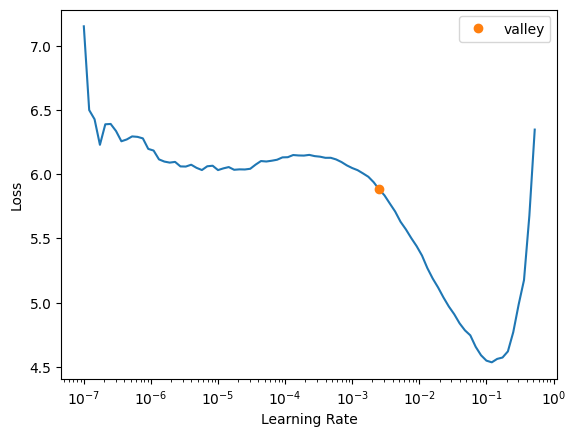

In [7]:
avg = "macro"
model_name = 'vit_base_patch16_224'
def vanilla(x=None,pretrained=None):
    return VanillaCNN(3,50)
learn = vision_learner(dls,model_name,loss_func=CrossEntropyLossFlat(),opt_func=Adam,metrics=[accuracy,Precision(average=avg),Recall(average=avg),F1Score(average=avg)])
lr = learn.lr_find()
print(lr)
learn.fit_one_cycle(EPOCH,lr_max=lr)

# Add the EarlyStoppingCallback to the list of callbacks
callbacks = [EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=3)]

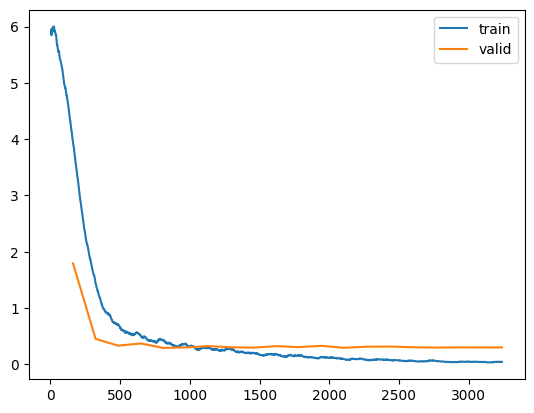

In [8]:
learn.recorder.plot_loss()

In [9]:
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

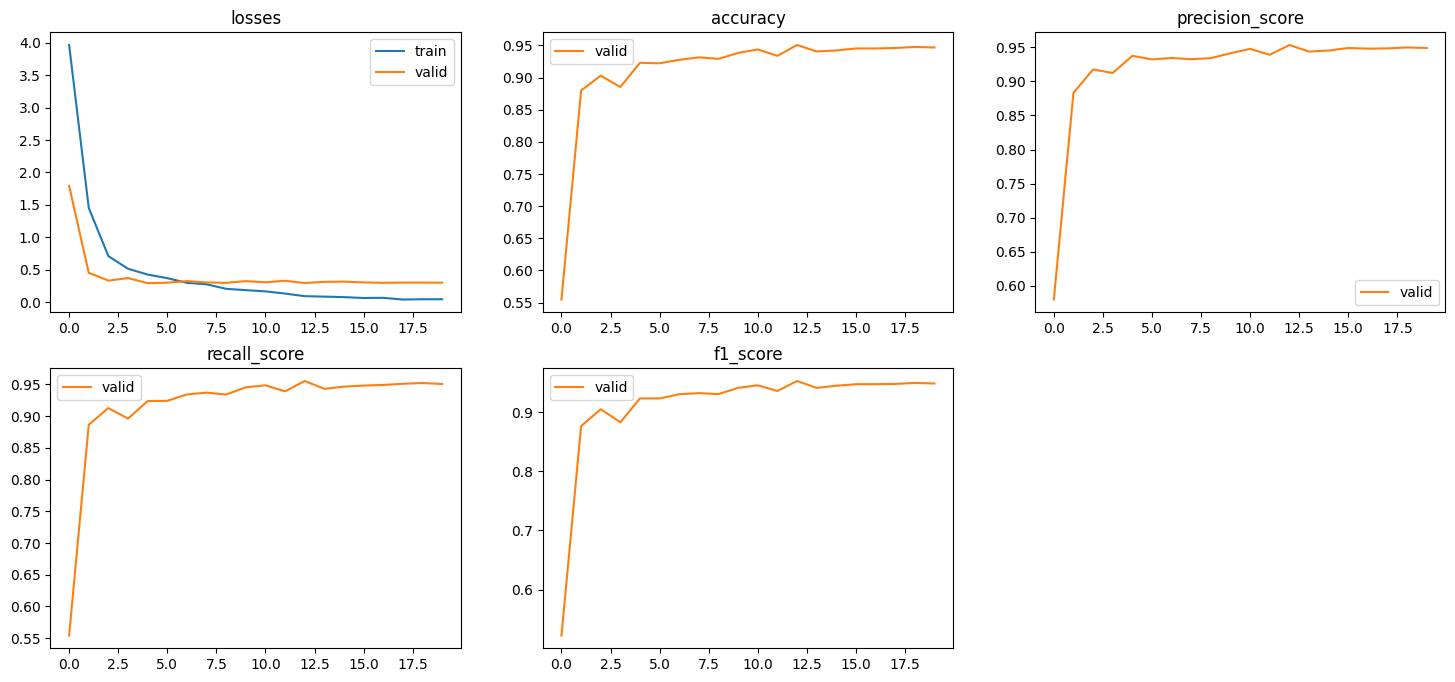

In [10]:
learn.recorder.plot_metrics()

In [11]:
result_df = pd.DataFrame(learn.recorder.values,columns=["train_loss","valid_loss","accuracy","precision_score","recall_score","f1_score"])
result_df.to_csv(f"{model_name}.csv",index=False)